In [74]:
import numpy as np
import pandas as pd

In [75]:
# 3. Load Dataset
df = pd.read_csv("Fraud.csv")
print("Shape of dataset:", df.shape)

Shape of dataset: (6362620, 11)


In [77]:
# Display the first 5 rows
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [16]:
# Display general information about the DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [17]:
# Display descriptive statistics
print(df.describe())

               step        amount  oldbalanceOrg  newbalanceOrig  \
count  6.362620e+06  6.362620e+06   6.362620e+06    6.362620e+06   
mean   2.433972e+02  1.798619e+05   8.338831e+05    8.551137e+05   
std    1.423320e+02  6.038582e+05   2.888243e+06    2.924049e+06   
min    1.000000e+00  0.000000e+00   0.000000e+00    0.000000e+00   
25%    1.560000e+02  1.338957e+04   0.000000e+00    0.000000e+00   
50%    2.390000e+02  7.487194e+04   1.420800e+04    0.000000e+00   
75%    3.350000e+02  2.087215e+05   1.073152e+05    1.442584e+05   
max    7.430000e+02  9.244552e+07   5.958504e+07    4.958504e+07   

       oldbalanceDest  newbalanceDest       isFraud  isFlaggedFraud  
count    6.362620e+06    6.362620e+06  6.362620e+06    6.362620e+06  
mean     1.100702e+06    1.224996e+06  1.290820e-03    2.514687e-06  
std      3.399180e+06    3.674129e+06  3.590480e-02    1.585775e-03  
min      0.000000e+00    0.000000e+00  0.000000e+00    0.000000e+00  
25%      0.000000e+00    0.000000e+00

In [18]:
# Check for missing values
print(df.isnull().sum())

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


In [19]:
merchant_mask = df['nameDest'].str.startswith('M')
dest_balance_zero_mask = (df['oldbalanceDest'] == 0.0) & (df['newbalanceDest'] == 0.0)
zero_dest_balance_count = df[dest_balance_zero_mask].shape[0]
total_count = df.shape[0]
print(f'Total transactions: {total_count}')
print(f'Transactions with zero dest balances: {zero_dest_balance_count}')
print(f'Percentage: {zero_dest_balance_count / total_count * 100:.2f}%')

Total transactions: 6362620
Transactions with zero dest balances: 2317282
Percentage: 36.42%


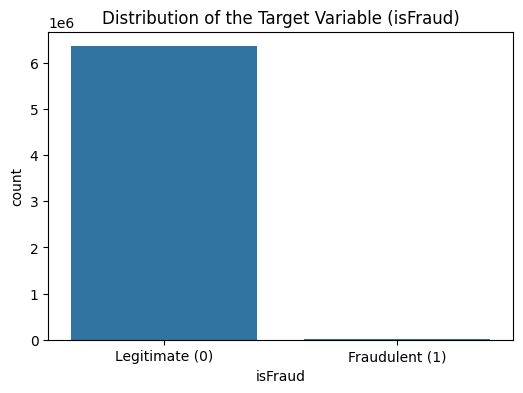

In [20]:
# Visualize the target variable distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='isFraud', data=df)
plt.title('Distribution of the Target Variable (isFraud)')
plt.xticks([0, 1], ['Legitimate (0)', 'Fraudulent (1)'])
plt.savefig('isFraud_distribution.png')
plt.show()

In [22]:
# Calculate the percentage of fraud
fraud_count = df['isFraud'].sum()
legit_count = len(df) - fraud_count
print(f'Legitimate Transactions: {legit_count} ({legit_count / len(df) * 100:.4f}%)')
print(f'Fraudulent Transactions: {fraud_count} ({fraud_count / len(df) * 100:.4f}%)')
print('This confirms a severe class imbalance, a common challenge in fraud detection.')

Legitimate Transactions: 6354407 (99.8709%)
Fraudulent Transactions: 8213 (0.1291%)
This confirms a severe class imbalance, a common challenge in fraud detection.


In [39]:
print(df.columns)

Index(['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest',
       'newbalanceDest', 'isFraud', 'type_CASH_OUT', 'type_DEBIT',
       'type_PAYMENT', 'type_TRANSFER', 'nameOrig_encoded',
       'nameDest_encoded'],
      dtype='object')


In [28]:
print(df.columns.tolist())

['step', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig', 'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud', 'isFlaggedFraud', 'type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER']


In [40]:
# Display the new structure
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 13 columns):
 #   Column            Dtype  
---  ------            -----  
 0   step              int64  
 1   amount            float64
 2   oldbalanceOrg     float64
 3   newbalanceOrig    float64
 4   oldbalanceDest    float64
 5   newbalanceDest    float64
 6   isFraud           int64  
 7   type_CASH_OUT     bool   
 8   type_DEBIT        bool   
 9   type_PAYMENT      bool   
 10  type_TRANSFER     bool   
 11  nameOrig_encoded  int64  
 12  nameDest_encoded  int64  
dtypes: bool(4), float64(5), int64(4)
memory usage: 461.2 MB


In [44]:
# 1. Calculate Error in Balance for Originating Customer
df['errorBalanceOrig'] = df['oldbalanceOrg'] - df['amount'] - df['newbalanceOrig']
# 2. Calculate Error in Balance for Destination Customer
# Note: For CASH-OUT and TRANSFER, the amount is added to the destination balance.
# For other types (PAYMENT, CASH-IN, DEBIT), the destination balance is not updated or is zero (Merchants).
df['errorBalanceDest'] = df['oldbalanceDest'] + df['amount'] - df['newbalanceDest']
# Display the new features and check for correlation with fraud
print(df[['isFraud', 'errorBalanceOrig', 'errorBalanceDest']].corr()['isFraud'].sort_values(ascending=False))

isFraud             1.000000
errorBalanceDest    0.055120
errorBalanceOrig    0.011283
Name: isFraud, dtype: float64


In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column            Dtype  
---  ------            -----  
 0   step              int64  
 1   amount            float64
 2   isFraud           int64  
 3   type_CASH_OUT     bool   
 4   type_DEBIT        bool   
 5   type_PAYMENT      bool   
 6   type_TRANSFER     bool   
 7   nameOrig_encoded  int64  
 8   nameDest_encoded  int64  
 9   errorBalanceOrig  float64
 10  errorBalanceDest  float64
dtypes: bool(4), float64(3), int64(4)
memory usage: 364.1 MB


In [53]:
print(df.columns)

Index(['step', 'amount', 'isFraud', 'type_CASH_OUT', 'type_DEBIT',
       'type_PAYMENT', 'type_TRANSFER', 'nameOrig_encoded', 'nameDest_encoded',
       'errorBalanceOrig', 'errorBalanceDest'],
      dtype='object')


In [54]:
# Separate features (X) and target (y)
X = df.drop('isFraud', axis=1)
y = df['isFraud']

In [56]:
from sklearn.preprocessing import StandardScaler
# Standardization (Step 1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [58]:
from sklearn.decomposition import PCA
import numpy as np
# We will choose a number of components that retains a high percentage of the variance (e.g., 95%).
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)
print(f'Original number of features: {X_scaled.shape[1]}')
print(f'Reduced number of features (95% variance): {X_pca.shape[1]}')
print(f'Cumulative variance explained by components: {np.sum(pca.explained_variance_ratio_):.4f}')

Original number of features: 10
Reduced number of features (95% variance): 8
Cumulative variance explained by components: 0.9849


In [60]:
# Create a DataFrame for the PCA components and the target variable
X_pca_df = pd.DataFrame(data = X_pca, columns = [f'PC{i+1}' for i in range(X_pca.shape[1])])
X_pca_df['isFraud'] = y.values
# Display the first few rows of the PCA-transformed data
print(X_pca_df.head())

        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0  1.760070 -1.031254 -0.656261  0.659149 -1.375994 -1.371078 -0.315072   
1  1.807577 -1.066263 -0.680242  0.711339 -0.597267 -1.370979 -0.313140   
2 -1.020833 -0.536181  1.028252  0.853222 -1.265244 -2.251737  2.543833   
3 -0.482896  1.502355 -0.979872  0.726565  1.390449 -1.304052 -0.258780   
4  1.255455 -0.593811 -0.483729  0.771408  0.083991 -1.439868 -0.208957   

        PC8  isFraud  
0  0.106202        0  
1  0.142672        0  
2  0.638635        1  
3  0.431820        1  
4 -0.396152        0  


In [63]:
# Split the data into training and testing sets
# Stratify is crucial here to ensure both sets have a similar proportion of fraud cases.
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
print(f'Original training set size: {X_train.shape[0]}')
print(f'Fraud cases in training set: {y_train.sum()}')

Original training set size: 4453834
Fraud cases in training set: 5749


In [64]:
# Apply SMOTE to the training data to handle imbalance
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
print(f'\nResampled training set size: {X_train_res.shape[0]}')
print(f'Fraud cases in resampled training set: {y_train_res.sum()}')


Resampled training set size: 8896170
Fraud cases in resampled training set: 4448085


In [66]:
from sklearn.tree import DecisionTreeClassifier
# Initialize and train the Decision Tree Classifier
dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_train_res, y_train_res)
# Make predictions on the original, *unbalanced* test set
y_pred_dt = dt_classifier.predict(X_test)
y_proba_dt = dt_classifier.predict_proba(X_test)[:, 1]
print('Decision Tree Model Trained Successfully.')

Decision Tree Model Trained Successfully.


In [69]:
from sklearn.metrics import (accuracy_score,confusion_matrix,classification_report,roc_auc_score,roc_curve)
import matplotlib.pyplot as plt
import seaborn as sns
# Accuracy
accuracy = accuracy_score(y_test, y_pred_dt)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.9980


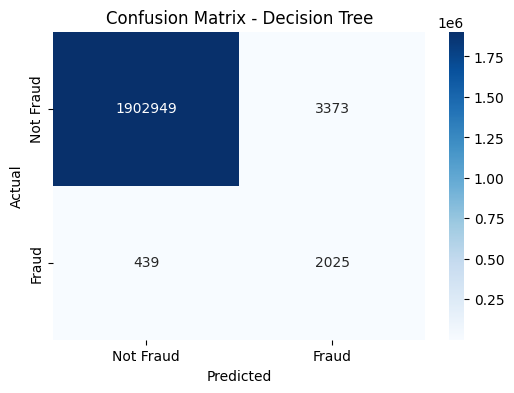

In [70]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_dt)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.title('Confusion Matrix - Decision Tree')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [71]:
# Classification Report
print('\nClassification Report:')
print(classification_report(y_test, y_pred_dt))


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906322
           1       0.38      0.82      0.52      2464

    accuracy                           1.00   1908786
   macro avg       0.69      0.91      0.76   1908786
weighted avg       1.00      1.00      1.00   1908786



In [72]:
# ROC-AUC Score
roc_auc = roc_auc_score(y_test, y_proba_dt)
print(f'ROC-AUC Score: {roc_auc:.4f}')

ROC-AUC Score: 0.9100


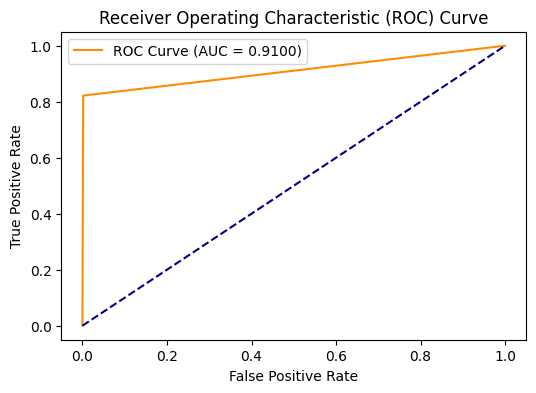

In [73]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba_dt)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, color='darkorange', label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

In [79]:
from sklearn.model_selection import cross_val_score
# Prepare the full scaled dataset (X) and target (y) without SMOTE for cross-validation
X_full = X  # X contains the full scaled features
y_full = y  # y contains the full target variable

In [80]:
# Initialize a new Decision Tree classifier
dt_cv = DecisionTreeClassifier(random_state=42)

In [81]:
# Perform 5-fold cross-validation using AUC as the scoring metric
cv_scores = cross_val_score(dt_cv, X_full, y_full, cv=5, scoring='roc_auc', n_jobs=-1)

In [83]:
print(f'\nMean CV AUC Score: {cv_scores.mean():.4f}')


Mean CV AUC Score: 0.6617


In [85]:
print(f'Standard Deviation of CV AUC Scores: {cv_scores.std():.4f}')

Standard Deviation of CV AUC Scores: 0.1358


In [86]:
print("This mean score provides a more reliable estimate of the model's generalization performance than the single test set score.")

This mean score provides a more reliable estimate of the model's generalization performance than the single test set score.
